In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
# data = yf.download()

In [15]:
class MeanRevBacktester():
    '''A backtester class for the Mean Reversion trading strategy
    '''

    def __init__(self,symbol,SMA,dev,start,end,tc):
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()

    def __repr__(self) -> str:
        rep = "MeanRevBacktester(symbol={} | SMA={} | dev={} | start={} | end={} )"
        return rep.format(self.symbol,self.SMA,self.dev,self.start,self.end)

    def get_data(self):
        raw = pd.read_csv("intraday_pairs.csv",parse_dates=["time"],index_col='time')
        raw = raw[self.symbol].to_frame()
        raw.columns = ['Price']
        raw['Returns'] = np.log(raw.div(raw.shift()))
        raw
        self.data = raw
        return raw
    
    def set_parameters(self,SMA=None,dev=None):
        if SMA is not None:
            self.SMA = SMA
            self.data['SMA'] = self.data['Price'].rolling(self.SMA).mean()
            self.data['LB'] = self.data['SMA']-self.data['Price'].rolling(self.SMA).std() * self.dev
            self.data['UB'] = self.data['SMA']+self.data['Price'].rolling(self.SMA).std() * self.dev
        
        if dev is not None:
            self.dev = dev
            self.data['LB'] = self.data['SMA'] - self.data['Price'].rolling(self.SMA).std() * self.dev
            self.data['UB'] = self.data['SMA'] + self.data['Price'].rolling(self.SMA).std() * self.dev

    def test_strategy(self):
        data = self.data.copy().dropna()
        #Determine the simple moving average of the instrument
        data['SMA'] = data['Returns'].rolling(self.SMA).mean()
        # Determine the UPPER and LOWER bounds Bolling Bands
        data['LB'] = data['SMA'] - data['Price'].rolling(self.SMA).std() * self.dev
        data['UB'] = data['SMA'] + data['Price'].rolling(self.SMA).std() * self.dev

        # Determine which position we then need to take depending on Price in relation to the SMA line
        data['Distance'] = data.Price - data.SMA
        # Defining long position for oversold stock
        data['Position'] = np.where(data['Price'] < data['LB'],1,np.nan)
        # Defining the short position for overbought stock
        data['Position'] = np.where(data['Price'] > data['UB'],-1,np.nan)
        # Defining the neutral position
        data['Position'] = np.where(data['Distance'] * data['Distance'].shift(1) < 0,0,data['Position'])
        # Forward filling the rows that don't have a preceding value
        data['Position'] = data.Position.ffill().fillna(0)
        # Absolute Returns of our strategy
        data['Strategy'] = data.Position.shift(1) * data['Returns']
        data.dropna(inplace=True)

        # Calculation of the Cumulative return
        data['C_Returns'] = data['Returns'].cumsum().apply(np.exp)
        data['C_Strategy'] = data['Strategy'].cumsum().apply(np.exp)
        data['Trades'] = data.Position.ffill().fillna(0).abs()

        self.results = data

        perf = data['C_Strategy'].iloc[-1]
        outperf = perf - data['C_Returns'].iloc[-1]

        return round(perf,6), round(outperf,6)
    def plot_results(self):
        '''Plots the performance of the trading strategy and the simple "buy and hold"
        '''
        if self.results is None:
            print('Run the .test_strategy() method first on the data.')
        else:
            title = "{} | SMA={} | dev={} | TC={}".format(self.symbol,self.SMA,self.dev,self.tc)
            self.results[['C_Returns','C_Strategy']].plot(title=title,figsize=(10,4))

    def optimize_parameters(self,sma_range,dev_range):
        #TODO: Finish of the optimize parameter method
        results = []
        combinations = list(product(range(*sma_range),range(*dev_range)))

        for combo in combinations(*range(sma_range),*range(dev_range)):
            self.set_parameters(combo[0],combo[1])
            results.append(self.test_strategy()[0])

        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]

        self.set_parameters(opt[0],opt[1])
        self.test_strategy()

        many_results = pd.DataFrame(data=combinations, columns=['SMA','dev'])
        many_results['performance'] = results
        self.results_overview = many_results

        return opt,best_perf

In [16]:
tester = MeanRevBacktester("EURUSD",SMA=30,start="2012-01-01",end="2017-12-31",tc=0.0007,dev=2)
tester

MeanRevBacktester(symbol=EURUSD | SMA=30 | dev=2 | start=2012-01-01 | end=2017-12-31 )

In [17]:
tester.test_strategy()

(1.076228, 0.139168)

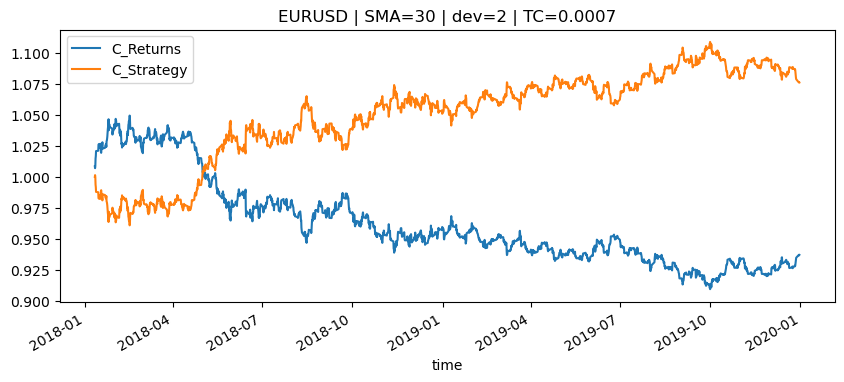

In [18]:
tester.plot_results()

In [19]:
tester.results

,Price,Returns,SMA,LB,UB,Distance,Position,Strategy,C_Returns,C_Strategy,Trades
time,,,,,,,,,,,
2018-01-11 10:00:00+00:00,1.204915,0.008455,0.000103,-0.009684,0.009889,1.204812,-1.0,0.000000,1.008491,1.000000,1.0
2018-01-11 16:00:00+00:00,1.203205,-0.001420,-0.000106,-0.009642,0.009429,1.203311,-1.0,0.001420,1.007060,1.001421,1.0
2018-01-11 22:00:00+00:00,1.205165,0.001628,0.000020,-0.009560,0.009601,1.205145,-1.0,-0.001628,1.008700,0.999793,1.0
2018-01-12 04:00:00+00:00,1.212530,0.006093,0.000186,-0.010189,0.010560,1.212344,-1.0,-0.006093,1.014865,0.993720,1.0
2018-01-12 10:00:00+00:00,1.214820,0.001887,0.000279,-0.011224,0.011782,1.214541,-1.0,-0.001887,1.016781,0.991847,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,0.000129,-0.006047,0.006306,1.119791,-1.0,-0.002092,0.936697,1.076647,1.0
2019-12-30 04:00:00+00:00,1.119940,0.000018,0.000145,-0.006655,0.006944,1.119795,-1.0,-0.000018,0.936713,1.076627,1.0
2019-12-30 10:00:00+00:00,1.120095,0.000138,0.000200,-0.007258,0.007659,1.119895,-1.0,-0.000138,0.936843,1.076478,1.0


TypeError: range expected at most 3 arguments, got 10